# Task 1

---

## Web scraping and analysis


### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from transformers import pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

c:\Users\sonal\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
data_path = r"C:\Users\sonal\OneDrive\Desktop\ba_data"

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100


reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

In [4]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()
pd.set_option('display.max_colwidth', None)

In [5]:
# Remove leading unwanted text

df = df[df['reviews'].str.contains('|', na=False)]
df['reviews'] = df['reviews'].str.split('|').str[1].str.strip()

# Reset the index
df.reset_index(drop=True, inplace=True)
df.iloc[:4]

,reviews
0,"My daughter and I were denied boarding on our business class flight from Madrid to Heathrow in March 25, 2023, the first leg on our return flight to Victoria, Canada. No reason was given for the denied boarding by the check in staff at the British Airways counter in Madrid, who said they were only agents and told us to call British Airways. We were three hours early for the flight and had valid passports. After many tries we finally reached British Airways by phone, but we were told to call Expedia which had booked the flights. Expedia confirmed that we had been bumped from the flight, with no explanation as to why. Expedia then began a long process of finding alternative flights. Over the next 24 hours we had numerous calls with both Expedia and British Airways. Incredibly, the next available flights were 9 days later on April 3. This was almost unbelievable, but after many many tries it was the best we could do. Even though these were Business Class tickets. Part of the problem was that apparently rules did not allow any changes to routing for any segment of the flight. This nine day delay was a major problem for us. I had to miss work and my daughter was missing school. Further, we received no compensation from British Airways, no penalty fee, and not any reimbursement of our expenses for staying the nine extra days. After our return I began the British Airways online complaint process, and submitted all supporting documents. I received an email reply and a case reference number. And then nothing. I sent numerous follow up emails, and received no replies. It is now months later, and still I have not heard from British Airways. This is shocking, and definitely the worst airline service I have received for my thousands of flights over many decades. I am a very patient person and this is the first time I have commented on this type of forum. I think the public should be made aware of extremely poor customer service at British Airways."
1,"Despite boarding being the usual free for all at LHR with groups 1-3 being called to board all at once. Whilst those passengers who had agreed to check in a bag in at the gate, getting to board before anyone else! However, the service on board was impeccable. Superb crew, friendly, attentive, interacting with passengers and generally appearing to be enjoying their job. Like BA in the old days and at its best. Food choice and quality seems to have improved too (no beef cheeks thankfully) and even the Club kitchen appears to have returned. Old style Club seating, but is at least better, and feels less cramped, on the 787's."
2,"Flight cancelled, no crew! 9th September 2023, not peak holiday period so why such bad management by BA? Sent to the gate left standing of over and hour and then flight cancelled. As were other on that day. Why does BA continue to provide such poor service - a national disgrace."
3,"The worst service ever, my baggage did not arrive on time. Both my flights were delayed. I will never fly them again. Even the food was bad and your service."


In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sonal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Data cleaning

In [33]:
# Data cleaning

my_stopwords = nltk.corpus.stopwords.words('english')
query_words=['british', 'airways', 'flight', 'airport', 'luggage', 'heathrow', 'bag', 'london', 'custom']
my_stopwords.extend(query_words)
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def clean_text(text, bigrams=False):
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    text_token_list = [word_rooter(word) if '#' not in word else word
                        for word in text_token_list] # apply word rooter
    if bigrams:
        text_token_list = text_token_list+[text_token_list[i]+'_'+text_token_list[i+1]
                                            for i in range(len(text_token_list)-1)]
    text = ' '.join(text_token_list)
    return text

# Apply the updated preprocessing function
df['reviews'] = df['reviews'].apply(clean_text)

df.head(3)

,Unnamed: 0,reviews
0,0,despit board usual free lhr group call board w...
1,1,cancel crew th septemb peak holiday period bad...
2,2,worst servic ever baggag arriv time flight del...


In [ ]:
# Data cleaning (simple)

# Modify the preprocess_text function
def preprocess_text(text):
    # Use regular expression to remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Apply the updated preprocessing function
df['reviews'] = df['reviews'].apply(preprocess_text)

df.head(3)

In [4]:
df = pd.read_csv(data_path+"\BA_reviews_cleaned.csv")

### Topic Modelling

In [34]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['reviews']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names_out()

print(tf.shape)
print(tf_feature_names)

(1000, 543)
['abl' 'absolut' 'accept' 'access' 'accommod' 'across' 'actual' 'add'
 'addit' 'advis' 'age' 'agent' 'ago' 'ahead' 'air' 'aircraft' 'airlin'
 'aisl' 'allow' 'almost' 'alreadi' 'also' 'altern' 'although' 'alway'
 'amaz' 'announc' 'anoth' 'answer' 'anyon' 'anyth' 'apolog' 'app' 'appal'
 'appear' 'area' 'around' 'arriv' 'ask' 'assist' 'attempt' 'attend'
 'attent' 'attitud' 'avail' 'averag' 'avio' 'avoid' 'aw' 'away' 'b' 'ba'
 'back' 'bad' 'bag' 'baggag' 'bar' 'basic' 'becom' 'bed' 'behind' 'best'
 'better' 'big' 'bit' 'board' 'boe' 'book' 'bottl' 'breakfast' 'bu' 'busi'
 'buy' 'cabin' 'call' 'came' 'can' 'cancel' 'cannot' 'card' 'care'
 'carrier' 'case' 'caus' 'champagn' 'chang' 'charg' 'check' 'chees'
 'chicken' 'choic' 'choos' 'citi' 'claim' 'class' 'clean' 'clear'
 'clearli' 'close' 'club' 'coffe' 'cold' 'collect' 'come' 'comfort'
 'compani' 'compens' 'complain' 'complaint' 'complet' 'confirm' 'connect'
 'contact' 'continu' 'control' 'cost' 'could' 'couldn' 'counter' 'coupl

In [35]:
number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

LatentDirichletAllocation(random_state=0)

In [36]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [37]:
no_top_words = 20
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,seat,369.2,’t,213.3,seat,225.5,cancel,253.4,hour,228.9,servic,124.6,ba,76.8,seat,295.2,check,188.3,thank,34.0
1,good,318.2,ba,123.7,ba,130.1,ba,233.7,day,186.3,staff,93.3,board,63.9,economi,192.2,ba,55.8,board,27.4
2,class,299.1,’,98.5,airlin,82.0,book,213.5,ba,184.5,meal,88.1,crew,60.9,premium,120.2,desk,51.8,ladi,27.4
3,busi,271.2,i,76.6,pay,73.9,refund,193.5,us,181.1,board,73.1,passeng,60.8,servic,119.4,hour,51.4,check,24.2
4,ba,263.8,fli,69.4,book,60.6,custom,148.1,get,137.0,serv,69.5,minut,55.5,crew,107.9,bag,42.7,husband,23.4
5,food,238.2,airlin,60.3,chang,55.0,call,132.5,told,132.5,drink,68.6,seat,53.9,food,104.5,baggag,41.8,singapor,23.3
6,time,198.6,one,58.8,charg,52.8,voucher,110.5,delay,130.3,crew,68.3,us,52.1,cabin,99.0,gate,41.7,custom,22.1
7,servic,188.5,year,55.7,staff,49.3,travel,110.3,call,127.1,offer,63.1,plane,48.8,leg,79.4,passeng,33.9,servic,21.5
8,crew,184.4,didn,55.3,paid,46.5,ticket,107.7,custom,119.8,cabin,62.2,could,47.0,time,73.2,queue,33.4,back,20.2
9,cabin,177.4,experi,54.3,busi,39.4,servic,92.9,time,113.8,late,57.1,announc,44.2,fli,70.3,us,33.1,help,19.7


In [12]:
df.to_csv(data_path+"\BA_reviews_cleaned.csv")

### Sentiment Analysis 

#### 1. Text Blob

In [6]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [7]:
df_cleaned = df.copy()

df_cleaned['polarity'] = df['reviews'].apply(lambda x: get_polarity(x))
# df_cleaned['subjectivity'] = df['reviews'].apply(lambda x: get_subjectivity(x))

In [8]:
positive = len(df_cleaned[df_cleaned['polarity']<0])
negative = len(df_cleaned[df_cleaned['polarity']>0])
neutral = len(df_cleaned[df_cleaned['polarity']==0])

In [9]:
print('positive {}, negative: {}, neutral: {}'.format(positive, negative, neutral))

positive 318, negative: 638, neutral: 44


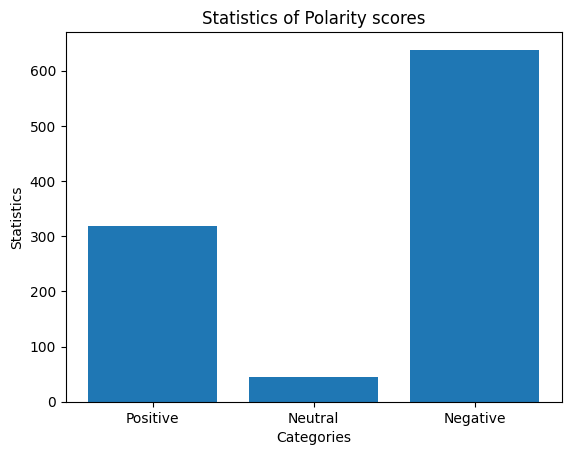

In [12]:
plt.bar(['Positive', 'Neutral', 'Negative'], [positive, neutral, negative])
plt.xlabel('Categories')
plt.ylabel('Statistics')
plt.title('Statistics of Polarity scores')
plt.show()

Text(0.5, 1.0, 'Standard Deviation of Polarity scores')

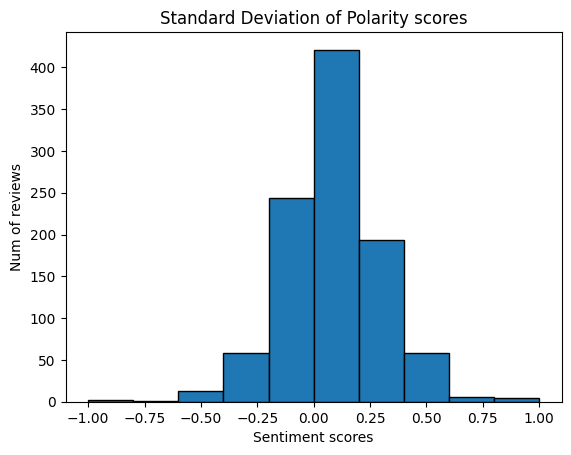

In [42]:
df_cleaned['polarity'].plot(kind='hist', edgecolor='black')
plt.xlabel('Sentiment scores')
plt.ylabel('Num of reviews')
plt.title('Standard Deviation of Polarity scores')

In [28]:
intervals = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
counts = {interval: 0 for interval in intervals}

# Count reviews in each interval
for interval in intervals:
    if interval == 1.0:
        reviews_in_interval = len(df_cleaned[df_cleaned['polarity'] == interval])
    else:
        reviews_in_interval = len(df_cleaned[(df_cleaned['polarity'] >= interval) & (df_cleaned['polarity'] < interval + 0.2)])
    
    counts[interval] = reviews_in_interval

# Print the counts in each interval
for interval, count in counts.items():
    print(f"Interval [{interval:.1f}, {interval + 0.2:.1f}]: {count}")


Interval [-1.0, -0.8]: 2
Interval [-0.8, -0.6]: 1
Interval [-0.6, -0.4]: 12
Interval [-0.4, -0.2]: 55
Interval [-0.2, 0.0]: 249
Interval [0.0, 0.2]: 415
Interval [0.2, 0.4]: 192
Interval [0.4, 0.6]: 65
Interval [0.6, 0.8]: 10
Interval [0.8, 1.0]: 2
Interval [1.0, 1.2]: 2


#### 2. Transformers

In [13]:
sentiment_pipeline = pipeline("sentiment-analysis")

def get_sentiment(text):
    return sentiment_pipeline(text)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [15]:
df_cleaned['sentiment'] = df['reviews'].apply(lambda x: get_sentiment(x)[0]['label'])
df_cleaned['score'] = df['reviews'].apply(lambda x: get_sentiment(x)[0]['score'])
df_cleaned

,Unnamed: 0,reviews,polarity,sentiment,score
0,0,daughter deni board busi class flight madrid h...,-0.008152,NEGATIVE,0.997678
1,1,despit board usual free lhr group call board...,0.278333,POSITIVE,0.719707
2,2,flight cancel crew th septemb peak holiday pe...,-0.366667,NEGATIVE,0.999272
3,3,worst servic ever baggag arriv time flight del...,-0.850000,NEGATIVE,0.991511
4,4,flight book holiday delay hour wifi avail ...,0.000000,NEGATIVE,0.991923
...,...,...,...,...,...
995,995,london lyon flight h delay flight durat gro...,-0.265000,NEGATIVE,0.999136
996,996,london boston seat next custom need extra seat...,0.400000,POSITIVE,0.985772
997,997,stockholm london standard configur short haul ...,0.304167,NEGATIVE,0.956295
998,998,amsterdam london arriv minut late three delay...,0.142857,NEGATIVE,0.944436


In [16]:
positive = len(df_cleaned[df_cleaned['sentiment']=='POSITIVE'])
negative = len(df_cleaned[df_cleaned['sentiment']=='NEGATIVE'])
print('positive {}, negative: {}'.format(positive, negative))

positive 116, negative: 884


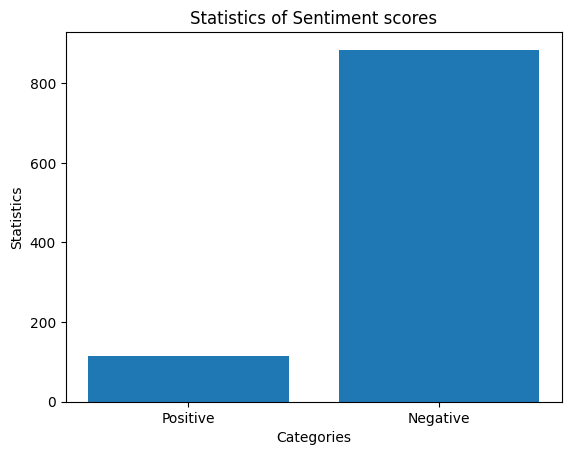

In [17]:
plt.bar(['Positive', 'Negative'], [positive, negative])
plt.xlabel('Categories')
plt.ylabel('Statistics')
plt.title('Statistics of Sentiment scores')
plt.show()

Text(0.5, 1.0, 'Standard Deviation of Sentiment scores')

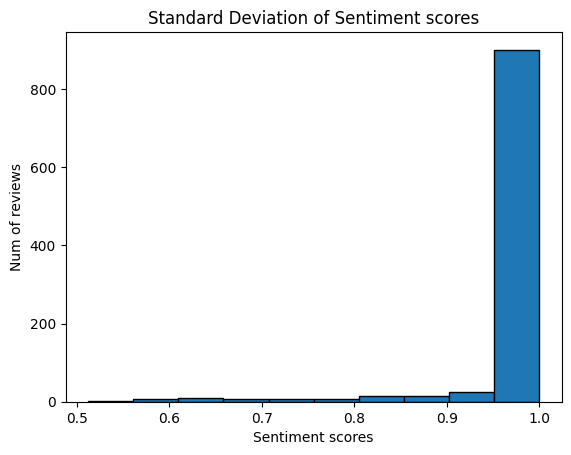

In [18]:
df_cleaned['score'].plot(kind='hist', edgecolor='black')
plt.xlabel('Sentiment scores')
plt.ylabel('Num of reviews')
plt.title('Standard Deviation of Sentiment scores')

### Word Cloud

In [47]:
df = pd.read_csv(data_path+"\BA_reviews.csv")

df = df[df['reviews'].str.contains('|', na=False)]
df['reviews'] = df['reviews'].str.split('|').str[1].str.strip()

# Reset the index
df.reset_index(drop=True, inplace=True)

my_stopwords = nltk.corpus.stopwords.words('english')
query_words=['british', 'airways', 'service', 'flight', 'airport', 'luggage', 'heathrow', 'bag', 'london', 'custom', 'ba', 'seat', 'aircraft', 'cabin']
my_stopwords.extend(query_words)

word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

def clean_text(text, bigrams=False):
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    text_token_list = [word_rooter(word) if '#' not in word else word for word in text_token_list] # apply word rooter
    if bigrams:
        text_token_list = text_token_list+[text_token_list[i]+'_'+text_token_list[i+1]
                                            for i in range(len(text_token_list)-1)]
    text = ' '.join(text_token_list)
    return text

# Apply the updated preprocessing function
df['reviews'] = df['reviews'].apply(clean_text)

df.head(3)

,Unnamed: 0,reviews
0,0,despit board usual free lhr group call board...
1,1,cancel crew th septemb peak holiday period ba...
2,2,worst ever baggag arriv time flight delay neve...


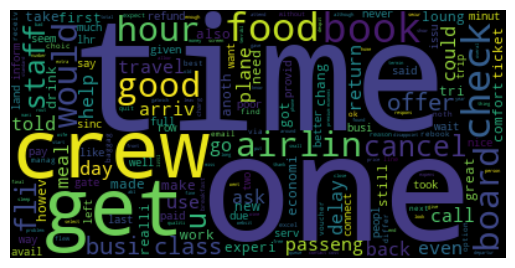

In [48]:
text = " ".join(review for review in df.reviews)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=my_stopwords).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud 2

In [7]:
df = pd.read_csv(data_path+"\BA_reviews.csv")

In [2]:
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
import random


In [8]:
# Remove leading unwanted text

df = df[df['reviews'].str.contains('|', na=False)]
df['reviews'] = df['reviews'].str.split('|').str[1].str.strip()

# Reset the index
df.reset_index(drop=True, inplace=True)
df.iloc[:4]

,Unnamed: 0,reviews
0,0,Despite boarding being the usual free for all ...
1,1,"Flight cancelled, no crew! 9th September 2023,..."
2,2,"The worst service ever, my baggage did not arr..."
3,3,4/4 flights we booked this holiday were delaye...


In [9]:
def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

nltk.LancasterStemmer
ls = LancasterStemmer()
lem = WordNetLemmatizer()
def lexicon_normalization(text):
    words = word_tokenize(text) 
    
    # 1- Stemming
    words_stem = [ls.stem(w) for w in words]
    
    # 2- Lemmatization
    words_lem = [lem.lemmatize(w) for w in words_stem]
    return words_lem

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sonal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sonal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
import string

def clean_text(text):

    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\'','', text)
    
    return text

In [12]:
def remove_stopword(text):
    stop_words = stopwords.words('english')
    query_words=['british', 'airways','ba', 'flight', 'trip','airport', 'airline','luggage', 'heathrow', 'bag', 'london', 'custom', 'seats', 'airplane', 'aircraft', 'food']
    stop_words.extend(query_words)

    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text

In [13]:
def tokenise(text):
    words = word_tokenize(text) 
    return words

In [14]:
# Cleaning data

df['reviews'] = df['reviews'].map(lambda x: re.sub(r'\W+', ' ', x))
df['reviews'] = df['reviews'].replace(r'\W+', ' ', regex=True)
df['reviews'] = df['reviews'].apply(lambda x: clean_text(x))
df['reviews'] = df['reviews'].apply(lambda x: remove_stopword(x))
df['reviews'] = df['reviews'].apply(lambda x: lexicon_normalization(x))
df.head()

,Unnamed: 0,reviews
0,0,"[despit, board, u, fre, lhr, group, cal, board..."
1,1,"[cancel, crew, septemb, peak, holiday, period,..."
2,2,"[worst, serv, ev, bag, ar, tim, flight, delay,..."
3,3,"[flight, book, holiday, delay, hour, wif, avai..."
4,4,"[tot, lack, respect, custom, book, fly, frankf..."


In [15]:
top = Counter([item for sublist in df['reviews'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,serv,904
1,u,696
2,tim,611
3,seat,591
4,hour,553
5,crew,458
6,check,451
7,get,442
8,on,437
9,class,425


In [16]:
import nbformat

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [17]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [18]:
def get_tweet_sentiment(text): 
    ''' 
    Utility function to classify sentiment of passed tweet 
    using textblob's sentiment method 
    '''
    # create TextBlob object of passed tweet text 
    analysis = TextBlob(text) 
    
    # set sentiment 
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negative'


In [20]:
df['sentiment']=df['reviews'].apply(lambda x: get_tweet_sentiment(' '.join(x)))
df.head()

,Unnamed: 0,reviews,sentiment
0,0,"[despit, board, u, fre, lhr, group, cal, board...",positive
1,1,"[cancel, crew, septemb, peak, holiday, period,...",negative
2,2,"[worst, serv, ev, bag, ar, tim, flight, delay,...",negative
3,3,"[flight, book, holiday, delay, hour, wif, avai...",neutral
4,4,"[tot, lack, respect, custom, book, fly, frankf...",negative


In [21]:
Positive_sent = df[df['sentiment']=='positive']
Negative_sent = df[df['sentiment']=='negative']
Neutral_sent = df[df['sentiment']=='neutral']

print('Number of tweets with positive sentiment', Positive_sent['sentiment'].count())
print('Number of tweets with negative sentiment', Negative_sent['sentiment'].count())
print('Number of tweets with neutral sentiment', Neutral_sent['sentiment'].count())

Number of tweets with positive sentiment 654
Number of tweets with negative sentiment 303
Number of tweets with neutral sentiment 43


In [22]:
#Most common Positive words
top = Counter([item for sublist in Positive_sent['reviews'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,serv,635
1,tim,437
2,u,436
3,seat,414
4,good,398
5,crew,348
6,check,320
7,board,316
8,hour,314
9,class,310


In [24]:
#Most common Negative words
top = Counter([item for sublist in Negative_sent['reviews'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,u,241
2,hour,226
3,tim,166
4,seat,161
5,on,152
6,cal,147
7,get,141
8,custom,138
9,ev,134
10,book,134


In [27]:
#Most common Neutral words
top = Counter([item for sublist in Neutral_sent['reviews'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

,Common_words,count
1,seat,16
2,cancel,15
3,staff,14
4,book,13
5,hour,13
6,on,13
7,flight,12
8,day,12
9,serv,12
10,delay,11


In [36]:
def plot_wordcloud(text, mask=None, max_words=100, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    
    wordcloud = WordCloud(background_color=color,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/kaggle/input/trump-tweets/'

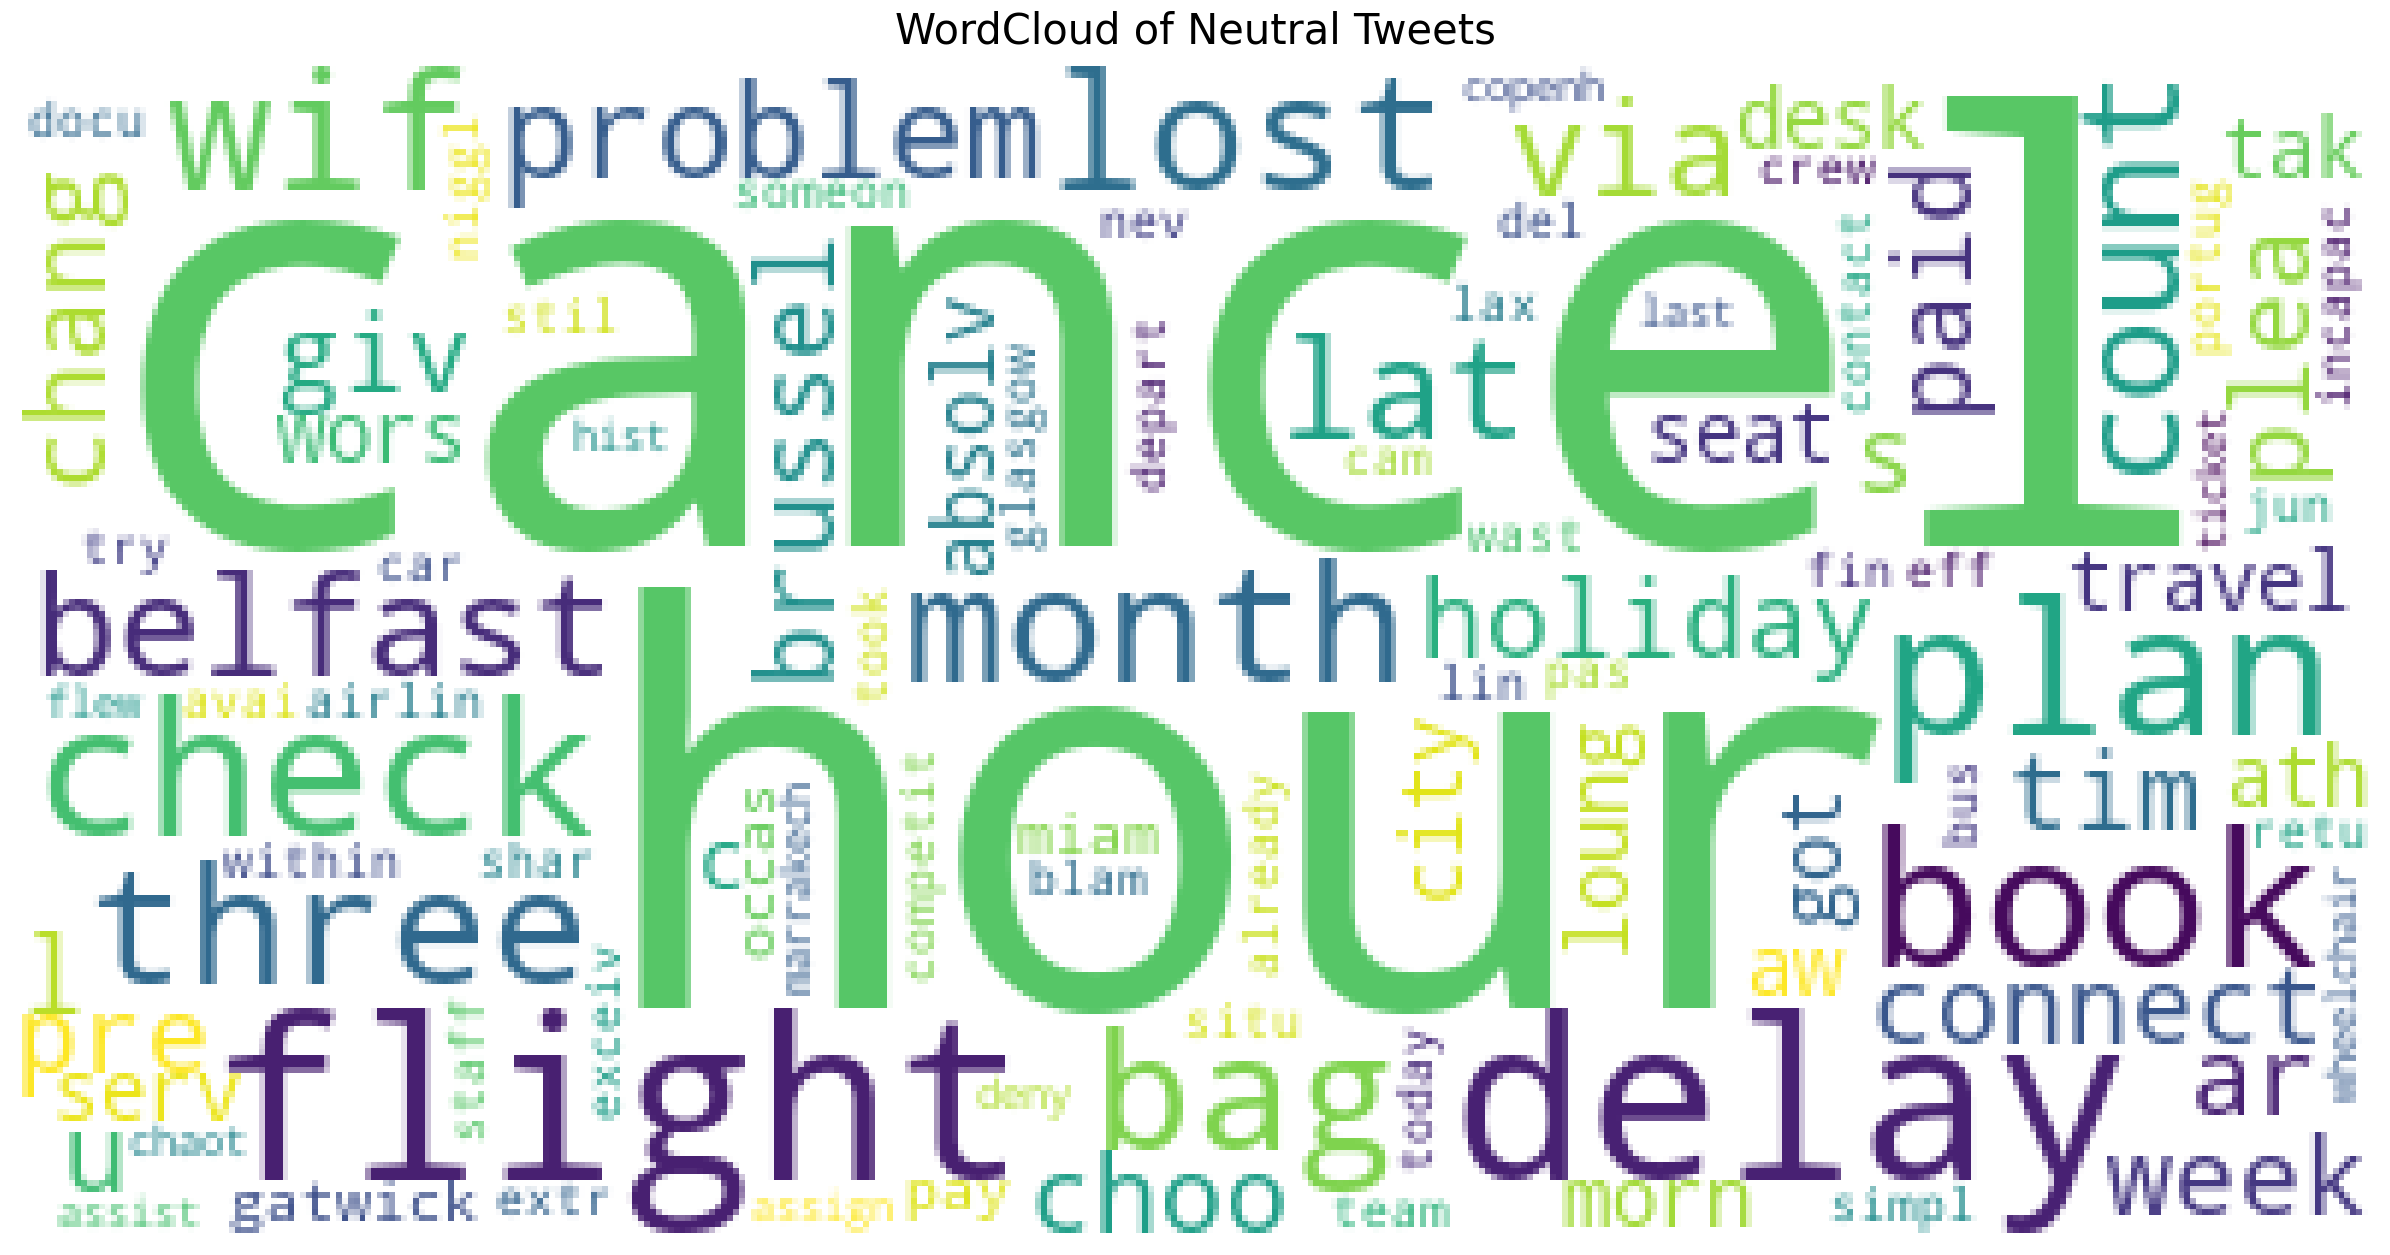

In [37]:
import numpy as np

#pos_mask = np.array(Image.open('/kaggle/input/tweet-mask/tweet_mask.png'))
plot_wordcloud(Neutral_sent.reviews,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")

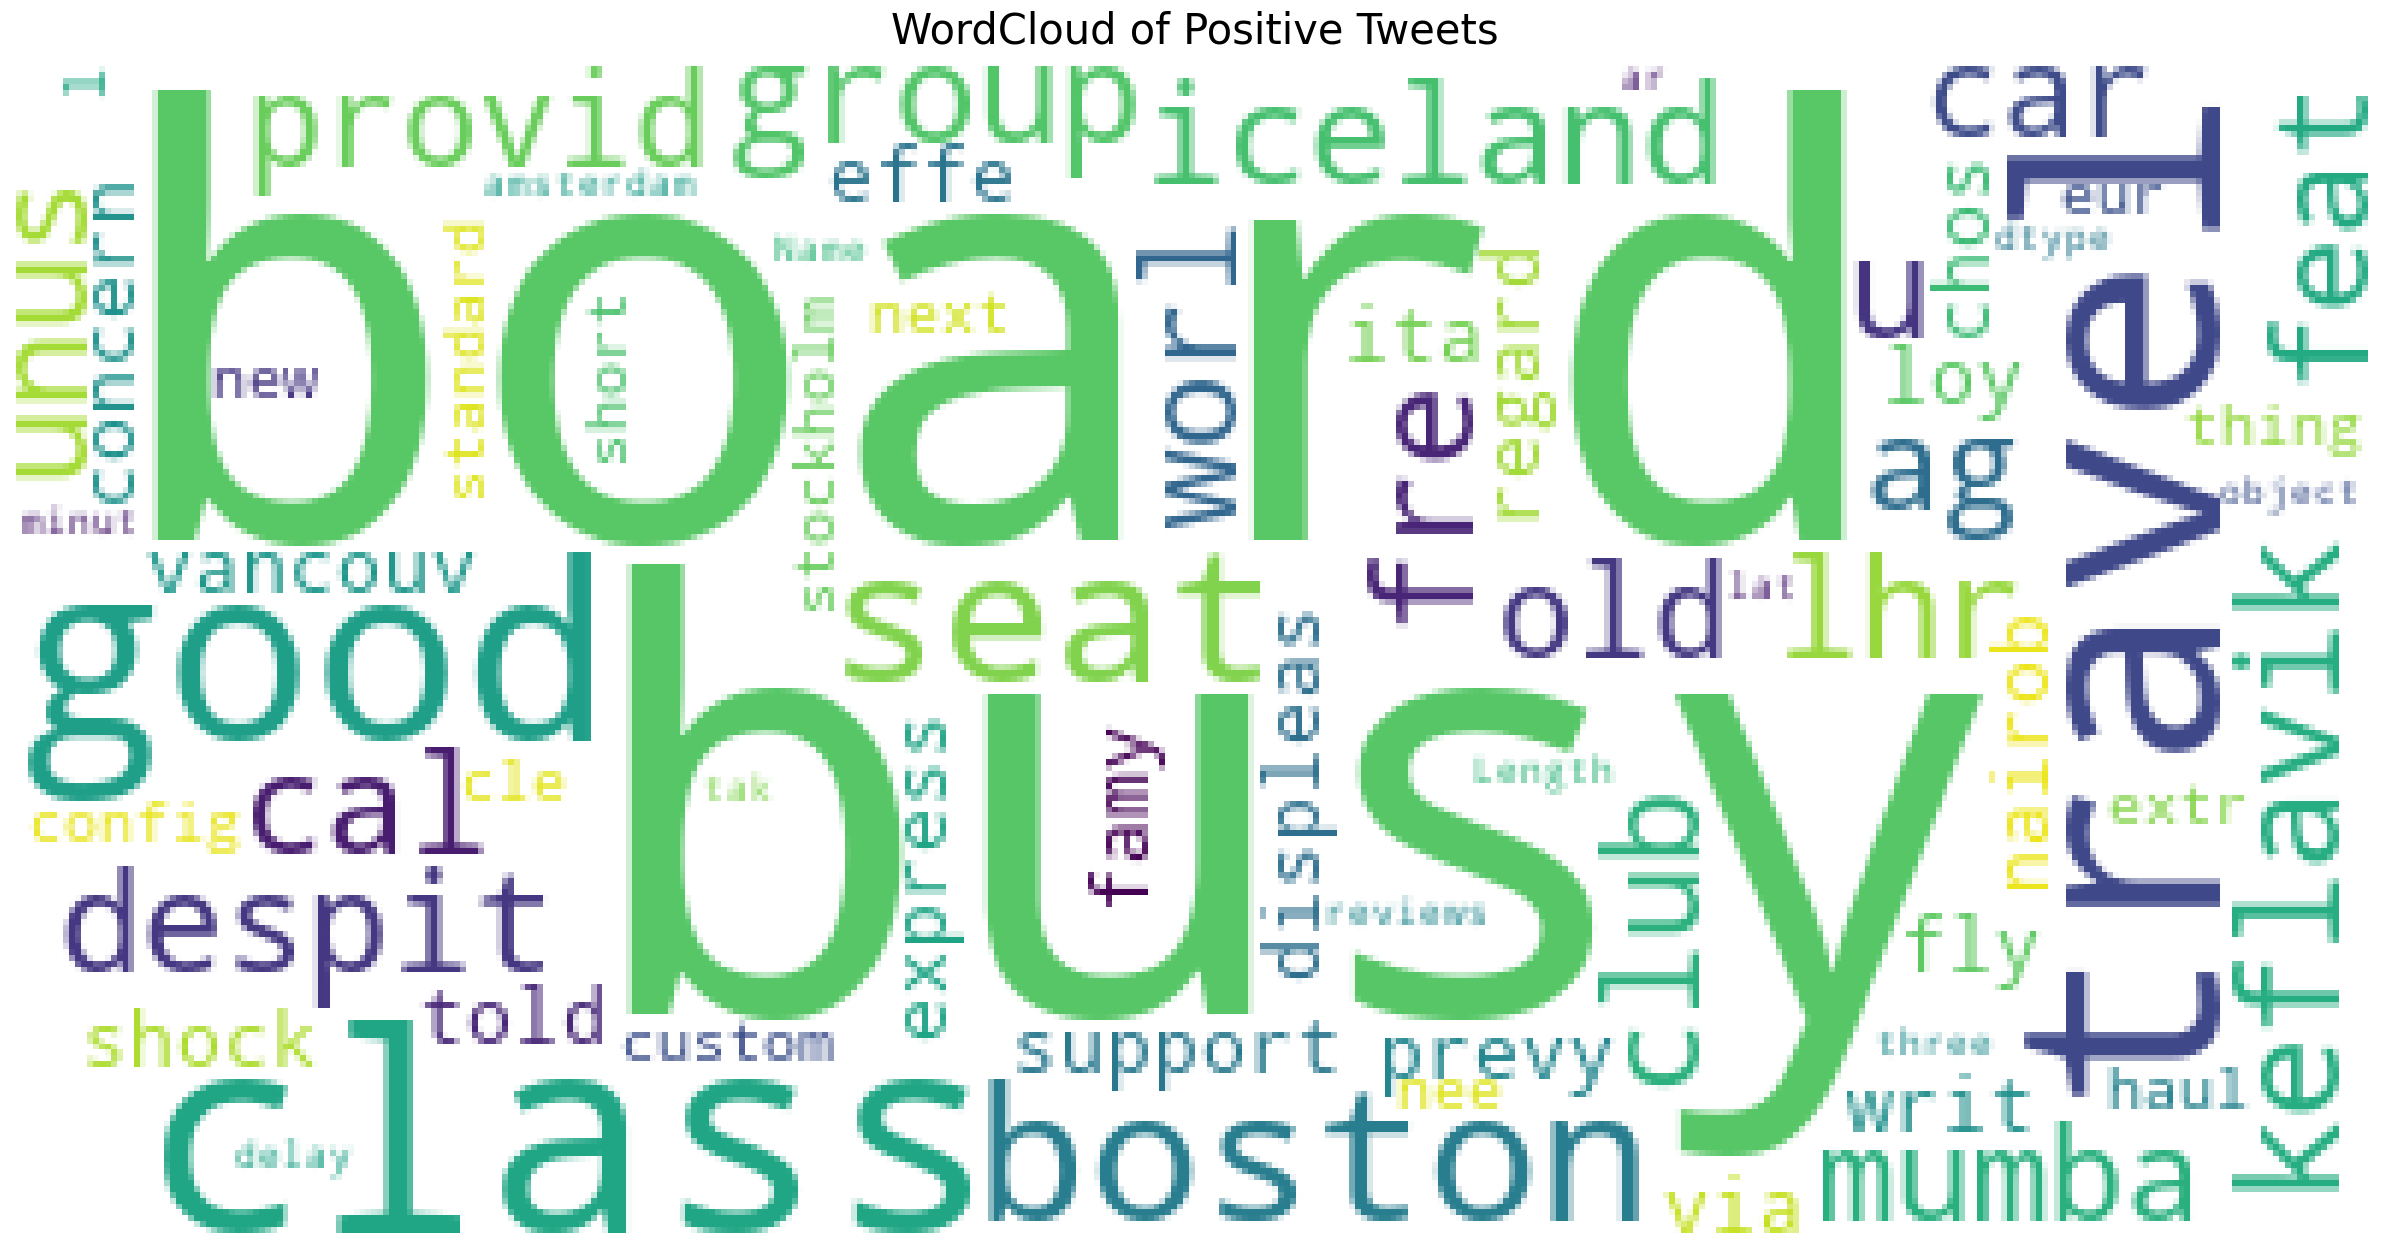

In [38]:
plot_wordcloud(Positive_sent.reviews,color='white',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

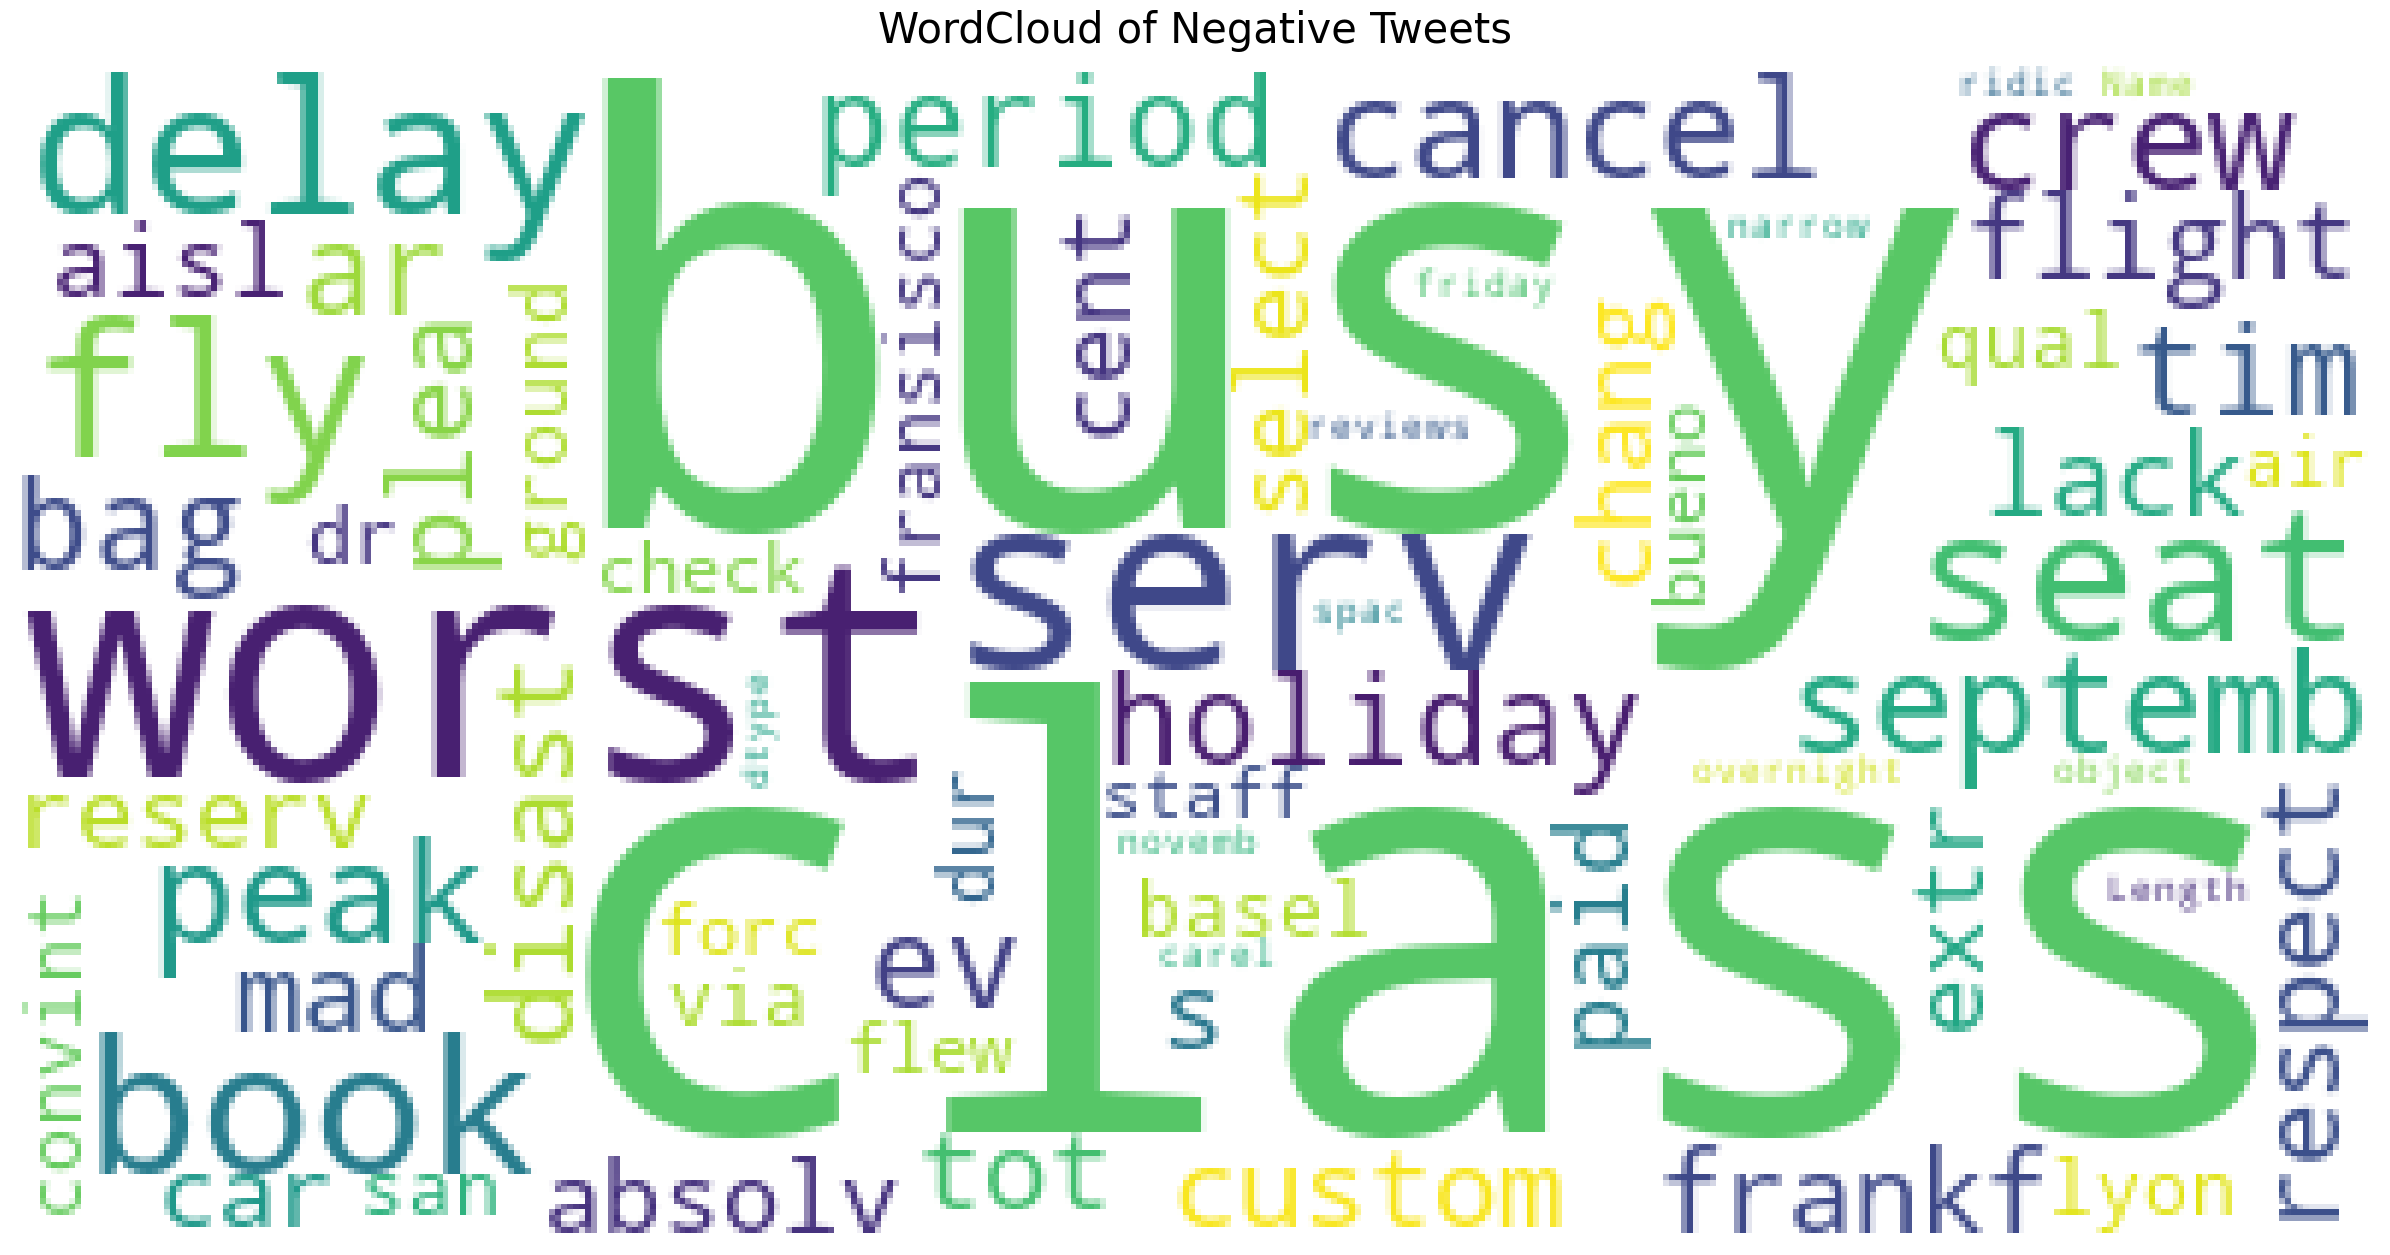

In [39]:
plot_wordcloud(Negative_sent.reviews,color='white',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")